# OPTION 1 : Deux modèles

L'idée est de faire un modèle qui prédit si oui ou non il y a un problème. Et si oui, dans un deuxième temps, prédire le type de problème.

Pourquoi : 
1. Il y a énormément de classe "sans problème", et plein de petites classes suivant le type de problème : C'est un unbalanced problem
2. Si on somme les toutes petites classes ensemble, on se retouve avec un quasi balanced problème avec autant de classe à 0 qu'à 1
3. Pour la détection de type de problème, c'est du multiclasse balanced.

Donc en découpant la question en deux, on doit gérer que deux problèmes de classif balanced.

Méthodologie:
1. Le Modèle 1 prend en entrée la BDD mais le Y est une variable binaire: {0:Pas de problème; 1:Problème}. Et prédit si oui ou non, il y a un souci. Au moment ou j'écris ces lignes j'ai un score d'environ 0.79 en AUC.
2. Pour les sorties flaguée en "classe à problème" le Modèle 1, on fait tourner le Modèle 2 pour détecter quel type de problème.
3. Jointure des résultats.

Points d'attentions:
1. Le Modèle 1 apprend sur la BDD normale, mais le trvaille que sur le Y en binaire
2. Le Modèle 2 apprend sur la BDD qu'avec des CLAIMS, et sort de la classif multiclasse
3. Le Modèle 1 joue un rôle de plafond de score, si on est à 0.8 sur le modèle 1, alors les deux modèles ne pourront jamais fiare mieux que 0.8.

# Imports des librairies de bases

On ajoutera celles qui manquent au fur et à mesure de nos besoins

In [45]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os, gc

# Définition de la seed pour le random

Très important pour qu'on voit les mêmes choses entre nos deux ordis

In [46]:
RANDOM_SEED = 42;
np.random.seed(RANDOM_SEED)

# Définition des paramètres pour Matplot

Rien de bien intéréssant

In [47]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Set des variables globales

Attention, je n'utilise les variables globales pour la gestion des fichiers. Sinon, c'est mort

In [48]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
DATA_PROCESSED = os.path.join(PROJECT_ROOT_DIR, "data_processed")

# Fonction pour load les libraires

En vrai, on a juste besoin de pd.read_csv, mais c'était pour faire joli

In [49]:
def load_data(file,data_path=DATA_PROCESSED, sep=','):
    csv_path = os.path.join(data_path, file)
    return pd.read_csv(csv_path, sep)

# On load des données


In [50]:
TX_data = load_data(file = "working_data.csv");
TX_data=TX_data.apply(pd.to_numeric, errors='ignore')

In [51]:
TX_data.head()

,SHIPPING_MODE,WARRANTIES_FLG,CARD_PAYMENT,COUPON_PAYMENT,RSP_PAYMENT,WALLET_PAYMENT,PRICECLUB_STATUS,REGISTRATION_DATE,BUYER_BIRTHDAY_DATE,BUYER_DEPARTMENT,...,WARRANTIES_PRICE_MIN,WARRANTIES_PRICE_MAX,SELLER_SCORE_COUNT_MIN,SELLER_SCORE_COUNT_MAX,ITEM_PRICE_MIN,ITEM_PRICE_MAX,PURCHASE_COUNT_MIN,PURCHASE_COUNT_MAX,SHIPPING_PRICE_MIN,SHIPPING_PRICE_MAX
0,NORMAL,False,1,0,1,0,UNSUBSCRIBED,2015,1992.0,34,...,0,0,10000,100000,0,10,0,5,0,0
1,NORMAL,False,1,0,0,0,UNSUBSCRIBED,2013,1952.0,77,...,0,0,10000,100000,0,10,0,5,0,0
2,NORMAL,False,0,0,0,1,PLATINUM,2013,1991.0,58,...,0,0,10000,100000,0,10,50,100,0,0
3,RECOMMANDE,True,1,0,0,0,UNSUBSCRIBED,2007,1955.0,31,...,5,20,10000,100000,50,100,500,1000,0,0
4,RECOMMANDE,False,1,0,1,0,PLATINUM,2010,1984.0,93,...,0,0,1000,10000,1000,5000,5,20,0,0


In [8]:
#TX_data.info()

## Sauvegarde des index

In [9]:
real_y = TX_data['CLAIM_TYPE']

### Prédire si oui ou non il y a un problème

In [10]:
# Fonction qui prend une ligne de la BDD en entrée, et dit "Si c'est - alors on renvoit 0, sinon 1
def b(row):
        return 0 if row['CLAIM_TYPE'] == '-' else 1;

In [11]:
# Je l'applique à la base de données
TX_data['IS_CLAIM'] = TX_data.apply(b, axis=1)

In [12]:
TX_data.drop('CLAIM_TYPE', axis=1, inplace = True)

In [13]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(TX_data, 
                                       test_size=0.2, 
                                       random_state=RANDOM_SEED, 
                                       stratify=TX_data["IS_CLAIM"]
                                      )
#del TX_data;

In [14]:
def datapreprocess(data):
    data=data.apply(pd.to_numeric, errors='ignore')
    
    # Y and X
    Y=data["IS_CLAIM"]
    X=data.drop("IS_CLAIM", axis=1,inplace=False)
    # Exclude Objets
    X=X.select_dtypes(exclude=['object'])
    
    # Work on fare
    from sklearn.preprocessing import Imputer
    imp = Imputer(missing_values='NaN',strategy='median', axis=1)
    X=pd.DataFrame(imp.fit_transform(X),columns=X.columns.values)
 
    return X, Y

In [15]:
X_train,Y_train=datapreprocess(train_set)
X_test, Y_test=datapreprocess(test_set)

del train_set, test_set;
gc.collect()

27

In [16]:
## test Rapide

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
rnd_clf = RandomForestClassifier(n_jobs=-1, 
                                 random_state=RANDOM_SEED)

In [41]:
# Modèle trouvé grâce à la cross validation

rnd_clf= RandomForestClassifier(
                                bootstrap=True, 
                                class_weight='balanced_subsample', 
                                criterion='gini',
                                max_depth=None, 
                                max_features='auto', 
                                max_leaf_nodes=18,
                                min_impurity_decrease=0.0, 
                                min_impurity_split=None,
                                min_samples_leaf=1, 
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0, 
                                n_estimators=500, 
                                n_jobs=1,
                                oob_score=True, 
                                random_state=RANDOM_SEED, 
                                verbose=0, 
                                warm_start=False)

In [42]:
from sklearn.metrics import roc_auc_score

In [43]:
rnd_clf.fit(X_train, Y_train);
y_pred_rf = rnd_clf.predict(X_test)

In [44]:
roc_auc_score(Y_test, y_pred_rf,average='weighted')

ValueError: multiclass format is not supported

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
    
conf_mx = confusion_matrix(Y_test, y_pred_rf)
plot_confusion_matrix(conf_mx)

In [25]:
y_predicted=pd.DataFrame(y_pred_rf)

In [26]:
y_predicted.columns=["Y"]

In [27]:
y_predicted.head()

,Y
0,0
1,1
2,0
3,1
4,0


In [28]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred_rf))

             precision    recall  f1-score   support

          0       0.82      0.75      0.78      9995
          1       0.77      0.84      0.80     10005

avg / total       0.80      0.79      0.79     20000



### Bilan: 

On prédit bien les zones en CLAIMS, donc ça peut être bien pour la suite.

# Modèle 2

In [29]:
TX_data.head()

,WARRANTIES_FLG,CARD_PAYMENT,COUPON_PAYMENT,RSP_PAYMENT,WALLET_PAYMENT,REGISTRATION_DATE,BUYER_BIRTHDAY_DATE,BUYER_DEPARTMENT,SELLER_SCORE_AVERAGE,SELLER_COUNTRY,...,Mean_BUYER_ID,STD_BUYER_ID,Count_Claims_BUYER_ID,Count_SELLER_ID,Mean_SELLER_ID,STD_SELLER_ID,Count_Claims_SELLER_ID,PCA_1,PCA_2,IS_CLAIM
0,0,1,0,1,0,2015,1992.0,34,46.0,"FRANCE, METROPOLITAN",...,0.800000,0.447214,4.0,44.0,0.5,0.505781,22.0,-203876.663031,-25937.586104,1
1,0,1,0,1,0,2014,1981.0,93,46.0,"FRANCE, METROPOLITAN",...,0.750000,0.500000,3.0,44.0,0.5,0.505781,22.0,-304465.724332,-25696.909632,1
2,0,1,0,0,0,2017,0.0,35,46.0,"FRANCE, METROPOLITAN",...,0.256410,0.442359,10.0,44.0,0.5,0.505781,22.0,-203876.778030,-25937.948454,0
3,0,0,1,0,0,2014,1964.0,92,46.0,"FRANCE, METROPOLITAN",...,0.285714,0.487950,2.0,44.0,0.5,0.505781,22.0,-203876.650358,-25937.610064,1
4,0,1,0,0,0,2013,1989.0,25,46.0,"FRANCE, METROPOLITAN",...,1.000000,0.000000,2.0,44.0,0.5,0.505781,22.0,-203876.657771,-25937.579497,1


In [30]:
TX_data["CLAIM_TYPE"] = real_y
TX_data.drop("IS_CLAIM", axis=1, inplace=True)

In [31]:
TX_data_md2 = TX_data.loc[TX_data['CLAIM_TYPE'] != "-"]

In [32]:
TX_data_md2=TX_data_md2.reset_index()
TX_data_md2.drop("index", inplace=True, axis=1)

In [33]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(TX_data_md2, 
                                       test_size=0.2, 
                                       random_state=RANDOM_SEED, 
                                       stratify=TX_data_md2["CLAIM_TYPE"]
                                      )
#del TX_data;

In [34]:
def datapreprocess(data):
    data=data.apply(pd.to_numeric, errors='ignore')
    
    # Y and X
    Y=data["CLAIM_TYPE"]
    X=data.drop("CLAIM_TYPE", axis=1,inplace=False)
    # Exclude Objets
    X=X.select_dtypes(exclude=['object'])
    
    # Work on fare
    from sklearn.preprocessing import Imputer
    imp = Imputer(missing_values='NaN',strategy='median', axis=1)
    X=pd.DataFrame(imp.fit_transform(X),columns=X.columns.values)
 
    return X, Y

In [35]:
X_train,Y_train=datapreprocess(train_set)
X_test, Y_test=datapreprocess(test_set)

del train_set, test_set;
gc.collect()

3777

In [36]:
rnd_clf= RandomForestClassifier(
                                bootstrap=True, 
                                class_weight='balanced_subsample', 
                                criterion='gini',
                                #max_depth=None, 
                                #max_features='auto', 
                                #max_leaf_nodes=18,
                                #min_impurity_decrease=0.0, 
                                #min_impurity_split=None,
                                #min_samples_leaf=1, 
                                #min_samples_split=2,
                                #min_weight_fraction_leaf=0.0, 
                                #n_estimators=30, 
                                n_jobs=1,
                                #oob_score=True, 
                                random_state=RANDOM_SEED, 
                                verbose=0, 
                                warm_start=False)

In [37]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
def multiclass_roc_auc_score(truth, pred):
    lb = LabelBinarizer()
    lb.fit(truth)
    return roc_auc_score(lb.transform(truth), lb.transform(pred), average="weighted")

In [38]:
rnd_clf.fit(X_train, Y_train);
y_pred_rf = rnd_clf.predict(X_test)
multiclass_roc_auc_score(Y_test, y_pred_rf)

0.63845971303043036

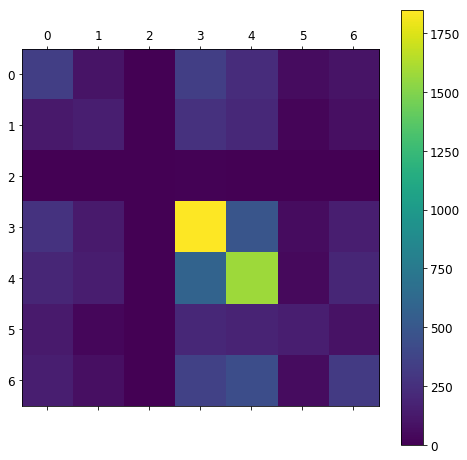

In [39]:
conf_mx = confusion_matrix(Y_test, y_pred_rf)
plot_confusion_matrix(conf_mx)

In [40]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred_rf))

                          precision    recall  f1-score   support

                 DAMAGED       0.28      0.29      0.28      1184
               DIFFERENT       0.24      0.18      0.21       856
                    FAKE       0.40      0.18      0.25        33
            NOT_RECEIVED       0.51      0.62      0.56      2962
SELLER_CANCEL_POSTERIORI       0.50      0.57      0.54      2757
               UNDEFINED       0.37      0.19      0.25       813
              WITHDRAWAL       0.34      0.23      0.27      1400

             avg / total       0.42      0.44      0.42     10005



In [ ]:
params_cv_long = {#'bootstrap':[True, False], 
                  #'max_depth':None,#list(range(1, 20)), 
                  'max_features':['auto', 'sqrt', 'log2'], 
                  'max_leaf_nodes':[2, 4, 8, 12, 16, 18],
                  'min_samples_leaf':list(range(1, 6)), 
                  'min_samples_split':list(range(2, 4)),
                  'n_estimators':list(range(10, 100, 25))
         }

In [ ]:
rf_to_cv= RandomForestClassifier(
                                bootstrap=True, 
                                class_weight='balanced_subsample', 
                                criterion='gini',
                                n_jobs=1,
                                oob_score=True, 
                                random_state=RANDOM_SEED, 
                                verbose=0, 
                                warm_start=False
                                )

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
rf_gs_cv = GridSearchCV(
                        estimator=rf_to_cv, 
                        param_grid=params_cv_long,
                        scoring=my_score,
                        n_jobs=-1, 
                        verbose=1, 
                        cv= 5
                        )

In [ ]:
rf_gs_cv.fit(X_train, Y_train)

In [ ]:
rf_gs_cv.best_estimator_

In [ ]:
y_pred_cv_rf = rf_gs_cv.predict(X_test)

In [ ]:
print("ROC score : {}".format(multiclass_roc_auc_score(Y_test, y_pred_cv_rf)))

In [ ]:
conf_mx = confusion_matrix(Y_test, y_pred_cv_rf)
plot_confusion_matrix(conf_mx)

In [ ]:
Sortie en erreur les copines!

In [ ]:
params_cv_long = {#'bootstrap':[True, False], 
                  #'max_depth':None,#list(range(1, 20)), 
                  'max_features':['auto', 'sqrt', 'log2'], 
                  'max_leaf_nodes':[2, 4, 8, 12, 16, 18],
                  'min_samples_leaf':list(range(1, 6)), 
                  'min_samples_split':list(range(2, 4)),
                  'n_estimators':list(range(10, 100, 25))
         }

In [ ]:
rf_to_cv= RandomForestClassifier(
                                    random_state=RANDOM_SEED,
                                    class_weight=None, 
                                    criterion='gini',
                                    oob_score=False,
                                    verbose=0,
                                    warm_start=False
                                )

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
rf_gs_cv = GridSearchCV(
                        estimator=rf_to_cv, 
                        param_grid=params_cv_long,
                        scoring='roc_auc',
                        n_jobs=-1, 
                        verbose=1, 
                        cv= 5
                        )

In [ ]:
rf_gs_cv.fit(X_train, Y_train)

In [ ]:
rf_gs_cv.best_estimator_

In [ ]:
y_pred_cv_rf = rf_gs_cv.predict(X_test)

In [ ]:
print("ROC score : {}".format(roc_auc_score(Y_test, y_pred_cv_rf)))

In [ ]:
conf_mx = confusion_matrix(Y_test, y_pred_cv_rf)
plot_confusion_matrix(conf_mx)

In [ ]:
# MODEL!

In [ ]:
## Scaler

Inutile pour les arbres, mais utiles pour les autres

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
## Normalizer

In [ ]:
from sklearn.preprocessing import Normalizer
normy = Normalizer()

In [ ]:
# PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA()

In [ ]:
# Feature Union

In [ ]:
from sklearn.pipeline import FeatureUnion

from sklearn.decomposition import KernelPCA
estimators = [('linear_pca', PCA(n_components=5)), 
                  ('kernel_pca', KernelPCA(n_components=5))]
combined = FeatureUnion(estimators)

In [ ]:
#combined.fit_transform(X_train)

In [ ]:
# Feature Selection

## Selection des variables avec une variance faible

Ici, on vire tout ce qu'il y a une probabilité de 0.8 d'être la 

In [ ]:
from sklearn.feature_selection import VarianceThreshold

In [ ]:
sel_vt = VarianceThreshold(threshold=(.8 * (1 - .8)))

In [ ]:
## Selection des K meilleures variables d'après le test de Chi2

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [ ]:
Nb_Var = 15

In [ ]:
Chi_select = SelectKBest(chi2, k=Nb_Var)
del Nb_Var

In [ ]:
## Selection par rapport à un modèle

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

In [ ]:
### Modèle de Selection

In [ ]:
clf = RandomForestClassifier(n_jobs=-1, 
                             random_state=RANDOM_SEED)

In [ ]:
### Contruction

In [ ]:
sfm_clf = SelectFromModel(clf)
del clf

# Metriques

D'abord, notre métrique à nous

In [ ]:
### Calcul l'AUC de chaque classe

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

In [ ]:
def multiclass_roc_auc_score(truth, pred):
    lb = LabelBinarizer()
    lb.fit(truth)
    return roc_auc_score(lb.transform(truth), lb.transform(pred), average="weighted")

In [ ]:
### precision_class_AUC (pas safe), est utilisée pour le scoring de modèle (version adaptée de précédement)

In [ ]:
def precision_class_AUC(estimator, X, y):
    return multiclass_roc_auc_score(y, estimator.predict(X))

In [ ]:
## Model!

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rnd_clf = RandomForestClassifier(n_jobs=-1, 
                                 random_state=RANDOM_SEED)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gb_clf=GradientBoostingClassifier(random_state=RANDOM_SEED)

In [ ]:
# Et on pipeline

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
clf = Pipeline([
    #('scaler', scaler), 
    #('norm', normy), 
    #('threshold', sel_vt), 
    #('SelectKBest', Chi_select), 
    #('reduce_dim', pca),
    #('feature_union', combined),
    #('feature_selection', sfm_clf),
    ('classification', gb_clf)
])


clf.fit(X_train, Y_train);
y_pred_rf = clf.predict(X_test)
multiclass_roc_auc_score(Y_test, y_pred_rf)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
    
conf_mx = confusion_matrix(Y_test, y_pred_rf)
plot_confusion_matrix(conf_mx)

In [ ]:
params = {'max_leaf_nodes': [4, 8],
          'max_depth' : [2, 4], 
          'n_estimators': [250, 500],
          'min_samples_leaf': list(range(1, 3)),
          'min_samples_split' : list(range(2, 3)),
         }

In [ ]:
rf_gs_cv = GridSearchCV(RandomForestClassifier(random_state=RANDOM_SEED, oob_score=True),
                              params,
                              scoring='f1_weighted',
                              n_jobs=-1, 
                              verbose=1)

In [ ]:
rf_gs_cv.fit(X_train, Y_train)

In [ ]:
rf_gs_cv.best_estimator_

In [ ]:
y_pred_cv_rf = rf_gs_cv.predict(X_test) 

In [ ]:
multiclass_roc_auc_score(Y_test, y_pred_cv_rf)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

In [ ]:
params_cv_long = {'bootstrap':True, 
                  'class_weight':None, 
                  'criterion':'gini',
                  'max_depth':None, 
                  'max_features':'auto', 
                  'max_leaf_nodes':[4, 8, 12, 16, 18],
                  'min_impurity_decrease':0.0, 
                  'min_impurity_split':None,
                  'min_samples_leaf':list(range(1, 6)), 
                  'min_samples_split':list(range(2, 4)),
                  'min_weight_fraction_leaf':0.0, 
                  'n_estimators':[100, 250, 500], 
                  'n_jobs':-1,
                  'oob_score':False, 
                  'random_state':RANDOM_SEED, 
                  'verbose':0, 
                  'warm_start':False
         }

In [ ]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=500, 
                                 max_leaf_nodes=16, 
                                 n_jobs=-1, 
                                 random_state=RANDOM_SEED))),
  ('classification', GridSearchCV(RandomForestClassifier(random_state=RANDOM_SEED), 
                              params,
                              scoring='f1_weighted',
                              n_jobs=-1, 
                              verbose=1))
])


In [ ]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(RandomForestClassifier(n_jobs=-1,random_state=RANDOM_SEED))),
  ('classification', RandomForestClassifier(, 
                                 n_jobs=-1, 
                                 random_state=RANDOM_SEED,
                                 ))
])


In [ ]:
clf.fit(X_train, Y_train)

In [ ]:
y_pred_rf = clf.predict(X_test)

In [ ]:
multiclass_roc_auc_score(Y_test, y_pred_rf)

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
params = {'max_leaf_nodes': [4, 8],
          'max_depth' : [2, 4], 
          'n_estimators': list(range(10, 50, 10)),
          'min_samples_leaf': list(range(1, 3)),
          'min_samples_split' : list(range(2, 3)),
         }

In [ ]:
rf_gs_cv = GridSearchCV(RandomForestClassifier(random_state=RANDOM_SEED, oob_score=True),
                              params,
                              scoring=precision_class_AUC,
                              n_jobs=-1, 
                              verbose=1)

In [ ]:
rf_gs_cv.fit(X_train, Y_train)
rf_gs_cv.best_estimator_

In [ ]:
y_pred_cv_rf = rf_gs_cv.predict(X_test) 

In [ ]:
multiclass_roc_auc_score(Y_test, y_pred_cv_rf)

In [ ]:
conf_mx = confusion_matrix(Y_test, y_pred_cv_rf)
plot_confusion_matrix(conf_mx)